In [1]:
import numpy as np
import pandas as pd
import math

import networkx as nx
from pyvis.network import Network

import ipysheet
from ipysheet import from_dataframe, to_dataframe , cell

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Functions

This cell defines transformation functions for describing pulse propagation, pulse transformation, and calculating interference on detectors. As well as auxiliary functions, such as visualization of the optical scheme in the form of graphs, graphing.

As arguments, the transformation functions take for a pulse: intensity (I), polarization (pol), coordinate (x), propagation direction (d=1,-1), time (t, arbitrary unit of incrementation step), and arm number in the optical scheme.

The pulse is defined by intensity $I$ and polarization column vector
$pol = \begin{smallmatrix}
 \alpha\\
 \beta
\end{smallmatrix}$. The polarization vector might be not normalized so the correct intensity would be $I||pol||^2$

In [3]:
'''
The main function describes optical pulse propagation. 
The pulse propagation ends when it is absorbed by a corresponding optical component, as detector,
or when the intensity falls below the extinction level.
When the pulse meets an optical component it is transformed by the corresponding function recall.
Therewith a new pulse may be generated by a recurrent function call.
The transformations on the optical components are described by their Jones matrices.
'''
def pulse(I, pol, x, d, t, arm):
    pulse_counter.append([1])
    for i in range(500000):        
        t += 1 #time incrementation
        x += d #coordinate shift
        I *= 10**(-0.00002) #attenuation, here d was taken as 1m
        if I*(np.linalg.norm(pol))**2 < extinction_level: #if the intensity drop lower the extinction level
            break        
        elif (x, arm) in detectors: #if returned to the detector
            res.append([t, I, pol, arm]) #that for which everything was started; records the pulse parameters on the detector           
            break         
        elif (x, arm) in elems.keys(): #if meets an optical component on its way            
            I, pol, x, d, t, arm = elems[x, arm][0](I, pol, x, d, t, arm, elems[x, arm][1])
            #recalls the function from the optical scheme description dictionary
            
#transformation functions for different optical components 
def mirror(I, pol, x, d, t, arm, cross):
    return I, np.dot(FM_matrix, pol), x, -d, t, arm #back reflected pulse

def mirror_PC(I, pol, x, d, t, arm, cross): #mirror with a connector
    pulse(connect_refl*I, pol, x, -d, t, arm) #create a parasitic reflected pulse
    return (1-connect_refl)*I, np.dot(FM_matrix, pol), x, -d, t, arm #reflected pulse

def FC_PC(I, pol, x, d, t, arm, cross): #FC/PC connector
    pulse(connect_refl*I, pol, x, -d, t, arm) #create a parasitic reflected pulse
    return (1-connect_refl)*I, pol, x, d, t, arm #attenuate the generic impulse

def pi_shift(I, pol, x, d, t, arm, cross): #pi phase shift
    return I, -pol, x, d, t, arm

def pi_shift_after(I, pol, x, d, t, arm, time): #pi phase shift on the way back, for example
    if t < time:
        return I, pol, x, d, t, arm
    else:
        return I, -pol, x, d, t, arm

def att_PC(I, pol, x, d, t, arm, dB): #attenuator with a connector
    pulse(connect_refl*I, pol, x, -d, t, arm)
    return (1-connect_refl)*I*10**(-0.1*dB), pol, x, d, t, arm

def att(I, pol, x, d, t, arm, dB):
    return I*10**(-0.1*dB), pol, x, d, t, arm
   
def BS_2x2(I, pol, x, d, t, arm, cross): #50х50 beamspliter
    port = cross[0].index(arm) #which port the pulse came to
    I1 = tr_rf_50[port][0][1]*I #define the output intensities
    I2 = tr_rf_50[port][1][1]*I
    arm1 = cross[0][tr_rf_50[port][0][0]] #define the output arms
    arm2 = cross[0][tr_rf_50[port][1][0]]
    pol1 = tr_rf_50[port][0][2]*pol #polarisation transformation
    pol2 = tr_rf_50[port][1][2]*pol
    x1 = cross[1][tr_rf_50[port][0][0]]#pulse coordinate in the output arms
    x2 = cross[1][tr_rf_50[port][1][0]]
    pulse(I1, pol1, x1, d, t, arm1) #output pulse 1
    return I2, pol2, x2, d, t, arm2 #output pulse 2

def PBS(I, pol, x, d, t, arm, cross):
    port = cross[0].index(arm) #which port the pulse came to
    if port: #if the pulse did not come to port 0
        arm = cross[0][0] #output arm is that connected to port 0
        pol = np.dot(tr_PBS[port][1], pol) #polarization transformation, with losses possibly
        x = cross[1][0]
        return I, pol, x, d, t, arm
    else:
        arm1 = cross[0][1]
        arm2 = cross[0][2]
        pol1 = np.dot(tr_PBS[0][0][1], pol)
        pol2 = np.dot(tr_PBS[0][1][1], pol)
        x1 = cross[1][1]
        x2 = cross[1][2]
        pulse(I, pol1, x1, d, t, arm1) #output pulse 1
        return I, pol2, x2, d, t, arm2 #output pulse 2

def cir(I, pol, x, d, t, arm, cross):
    port = cross[0].index(arm) #which port the pulse came to
    arm = cross[0][tr_cir[port][0]] #define the output arm
    x = cross[1][tr_cir[port][0]] #pulse coordinate in the output arms
    I *= tr_cir[port][1] #intensity change due to the losses
    return I, pol, x, d, t, arm

#arbitry wave-plate-like transformation
def pol_rotation(I, pol, x, d, t, arm, angles):
    alpha, phi = angles
    matrix = np.array([[np.e**(1j*phi)*np.cos(alpha)**2+np.sin(alpha)**2, np.sin(2*alpha)*(np.e**(1j*phi)-1)/2],
                      [np.sin(2*alpha)*(np.e**(1j*phi)-1)/2, np.e**(1j*phi)*np.sin(alpha)**2+np.cos(alpha)**2]])
    return I, np.dot(matrix, pol), x, d, t, arm

def half_wave_plate(I, pol, x, d, t, arm, alpha):
    return pol_rotation(I, pol, x, d, t, arm, (np.pi, alpha))

def quarter_wave_plate(I, pol, x, d, t, arm, alpha):
    return pol_rotation(I, pol, x, d, t, arm, (np.pi/2, alpha))

#Intensity calculation concerning the interference
#Summarizes amplitudes (for a time window on a detector) and then calculates the intensity
def inter_intensity(col):
    return np.linalg.norm(np.sum(col))**2

#run and plot
def run_plot(I, pol, x, d, t, arm):
    pulse(I, pol, x, d, t, arm)
    reflects = pd.DataFrame(res, columns = ['Cycle', 'Intensity', 'Polarization', 'Detector'])
    reflects['Light'] = np.sqrt(reflects.Intensity)*reflects.Polarization
    interference = reflects[['Cycle', 'Detector', 'Light']]
    interference = interference.groupby(['Detector', 'Cycle']).aggregate({'Light':inter_intensity}).reset_index()
    interference = interference[interference.Light >= extinction_level]

    #plot graphs
    grp = interference.groupby(['Detector'])
    fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2,
                            gridspec_kw=dict(hspace=0.2))
    for key, ax in zip(grp.groups.keys(), axs.flatten()):
        adf = grp.get_group(key)
        ax.stem(adf.Cycle, adf.Light)
        ax.set_yscale('log')
        ax.set_ylabel('intensity',color='blue')
        ax.set_xlabel('distance',color='blue')
        ax.set_title('Detector '+str(key))
        ax.grid()
    plt.show()
    return interference

def plot(df):
    grp = df.groupby(['Detector'])
    fig, axs = plt.subplots(figsize=(15,4), nrows=1, ncols=2,
                            gridspec_kw=dict(hspace=0.2))
    for key, ax in zip(grp.groups.keys(), axs.flatten()):
        adf = grp.get_group(key)
        ax.stem(adf.Cycle, adf.Light)
        ax.set_yscale('log')
        ax.set_title('Detector '+str(key))
        ax.grid()
    plt.show()

#visibility calculation function
#for a correct calculation, the paths between the beamsplitter and detectors must be equal
#i.e. intensities must correspond to the same time window
def visibility(df, cycle):
    arr = df[df.Cycle == cycle].Light.to_numpy() #an array of intensities in the time window taken
    if arr.shape[0] == 0:
        return 'NaN'
    elif arr.shape[0] == 1:
        return 1
    else:
        return (arr[0]-arr[1]) / (arr[0]+arr[1])
 


def build_graph(elements):
    '''
    Builds networkx graph for visualizing optical scheme.
    
    Parameters:
        elements: dictionary, describing optical scheme.

    Returns:
        networkx graph object.
    '''

    # building the dictionary of all components of optical scheme
    # key - one of the (coordinate, arm) pair of the optical component
    # value - a set of all (coordinate, arm) pairs belonging to tbe corresponding component
    components = {}

    seen = set() # here we saves all (coordinate, arm) already seen to make eliminate duplicate components
    for k, v in elements.items():
        if k not in seen:
            components[k] = set()
            if isinstance(v[1], tuple) and isinstance(v[1][0], tuple):
                for i in range(0, len(v[1][0])):
                    p = (v[1][1][i], v[1][0][i])
                    seen.add(p)
                    components[k].add(p)
            else:
                seen.add(k)
                components[k].add(k)

    # creating empty graph
    nxg = nx.empty_graph()

    # adding all components to the graph
    for c in components:
        try:
            # this works in case of elements[c][0] is function
            nxg.add_node(str(c), size=15, label=elements[c][0].__name__)
        except:
            # other case
            nxg.add_node(str(c), size=15, label=str(elements[c][0]))

    # determining all arm numbers of the optical scheme
    arms = {x[1] for x in set.union(*components.values())}

    # for all arm adding edges for every component pair along the optical path
    for arm in arms:
        # filtering components, connected to the given arm
        cinarm = {c: v for c, v in components.items() if any([k[1] == arm for k in v])}

        # representing components using another dict:
        # key - one of the (coordinate, arm) pair of the optical component
        # value - coordinate of the component relative to the given arm
        cinarm = {c: [k for k in v if k[1] == arm][0][0] for c, v in cinarm.items()}

        # sorting components by relative coordinate
        cinarm = sorted(cinarm.items(), key=lambda item: item[1])

        # adding adges to the graph along the optical path
        for i in range(0, len(cinarm)-1):
            nxg.add_edge(str(cinarm[i][0]), str(cinarm[i+1][0]), label=arm)

    return(nxg)


Next, constants are described such as the reflection from the connector, the threshold pulse extinction, the Jones matrices for the corresponding components. The beamsplitter is described by a dictionary in which the input and output ports, the change in intensity, and the phase shift are assigned.

In [4]:
#Constants
connect_refl = 0.01 #reflected amount of intensity
extinction_level = 1e-8

#Jones matrix for Faraday mirror
FM_matrix = np.array([[0, -1],
                      [1, 0]])
#Polarization beamsplitter, port0 - common; port1 and port2 - for orthogonal polarizations
#PBS10_matrix - from port1 to port0, and so on
PBS10_matrix = np.array([[1, 0],
                         [0, 0]])
PBS20_matrix = np.array([[0, 0],
                         [1, 0]])
PBS01_matrix = np.array([[1, 0],
                         [0, 0]])
PBS02_matrix = np.array([[0, 1],
                         [0, 0]])

tr_PBS = {
    0:((1, PBS01_matrix), (2, PBS02_matrix)),
    1:(0, PBS10_matrix),
    2:(0, PBS20_matrix)
}

#beamsplitter 50/50 transformation function
# 0, 1 - input ports, 2, 3 - output ports
#from the port 0 send to the port 2 with 0.5 intensity and with 1 phase; in the port 3 - 0.5 intensity i phase; and so on.
tr_rf_50 = {
    0:((2, 0.5, 1), (3, 0.5, 1j)),
    1:((2, 0.5, 1j), (3, 0.5, 1)),
    2:((1, 0.5, 1j), (0, 0.5, 1)),
    3:((0, 0.5, 1j), (1, 0.5, 1))
}

#transformation function of an ideal circulator
#in the tuple the first element - port, the second - intensity
tr_cir = {
    0:(1, 1),
    1:(2, 1),
    2:(0, 0),
}

## Optical scheme description
The scheme is described as a dictionary 'elems'. The key is a tuple of coordinate and arm, the value is a tuple of the function name for the optical component, and so-called crossing. Crossing makes sense only for components with more than 2 pigtails, for the others, you can put anything, for example, None. For the crossing tuple, element 0 is the correspondence between ports and arms. Index - port number, value - arm number. Element 1 - is the correspondence between ports and coordinates, index is the port number as well, value is the new coordinate value. Here coordinates are indicated in meters everywhere, which corresponds to rather rough - qualitative - simulation.

For components with crossing, it is necessary to describe separately the keys in the form of coordinates and arms for all involved ports. So the description turns out to be excessed. It is reasonable to check the correspondence between coordinates and ports in the key with coordinates and ports in the crossing.

Example dictionary element:

(25, 0): ( BS_2x2, ((0, 3, 2, 1), (25, 30, 0, 0)))

If the pulse reaches coordinate 25 in arm 0, then the function for the beam splitter BS_2x2 is started, which is connected as follows:

port 0, arm 0, coordinate 25;
port 1, arm 3, coordinate 30;
port 2, arm 2, coordinate 0;
port 3, arm 1, coordinate 0.

To correctly specify the placement of optical components, it is recommended to draw a diagram with the designation of the components, their port numbers, arm numbers, and port connection coordinates.

We can fill in the coordinates of the optical elements into the table interactively. We have a table like this:
![title](table.png)
We enter here the coordinates of the elements and their characteristics 
The further script sorts the data, and also translates into the required data types (Date_Frame, dictionary)


In [5]:

print("How many components do you have?") # The components include the coordinates of the detectors and the laser
N = int(input()) 

        
sheet1 = ipysheet.sheet(rows = N+2, columns = 10)  # Build a table.                                                                                                 
cell1 = ipysheet.cell(1, 0, 'Components') 
cell2 = ipysheet.cell(0, 1, 'Port1')
cell3 = ipysheet.cell(0, 3, 'Port2') 
cell4 = ipysheet.cell(0, 5, 'Port3') 
cell5 = ipysheet.cell(0, 7, 'Port4') 
cell6 = ipysheet.cell(0, 9, 'Other')
cell7 = ipysheet.cell(1, 1, 'Coor')
cell8 = ipysheet.cell(1, 2, 'Arm') 
cell9 = ipysheet.cell(1, 3, 'Coor')
cell10 = ipysheet.cell(1, 4, 'Arm')
cell11 = ipysheet.cell(1, 5, 'Coor')
cell12 = ipysheet.cell(1, 6, 'Arm')
cell13 = ipysheet.cell(1, 7, 'Coor')
cell14 = ipysheet.cell(1, 8, 'Arm')


for i in range(2,N+2):  # Here I create empty cells
    for j in range(1,10):
        cell(i,j,0)
    cell(i,0,None)
sheet1


How many components do you have?
7


Sheet(cells=(Cell(column_end=0, column_start=0, row_end=1, row_start=1, type='text', value='Components'), Cell…

In [11]:
a = ipysheet.to_dataframe(sheet1)
    
sorted_df = a[2:N+2].sort_values(by=['C','B']).reset_index(drop = True)        # Sorting the table by columns

sorted_df.rename(columns = {'A':'Components', 'B':'Coor(Port1)',         

                              'C':'Arm(Port1)', 'D':'Coor(Port2)', 'E':'Arm(Port2)', 'F':'Coor(Port3)', 'G':'Arm(Port3)', 'H':'Coor(Port4)','I':'Arm(Port4)','J':'Other'}, inplace = True)


            
z = 0            # counter of removed components

detectors = []   # creating a list of detectors
xL = 0 #Laser coordinate
arm0 = 0 #Laser arm

for i in range(0,N):
    
    if sorted_df['Components'][i] == 'FC_PC' or sorted_df['Components'][i] == 'mirror':
        sorted_df['Other'][i] = None
        
    elif sorted_df['Components'][i] == 'pol_rotation':              #Here I remove the att and the pol_rotation if they are not in the circuit
        if sorted_df['Other'][i] == 0.000:
            sorted_df = sorted_df.drop(index=[i])
            z = z+1
        else:
            b = sorted_df['Other'][i].split(',')
            b = [math.radians(int(item)) for item in b]
            sorted_df['Other'][i] = tuple(b)
            
    elif sorted_df['Components'][i] == 'att':
         if sorted_df['Other'][i] == 0.000:
            sorted_df = sorted_df.drop(index=[i])
            z = z+1
    elif sorted_df['Components'][i] == 'detector':
        detectors.append((int(sorted_df['Coor(Port1)'][i]),sorted_df['Arm(Port1)'][i]))
        sorted_df = sorted_df.drop(index=[i])
        z = z+1
        
    elif sorted_df['Components'][i] == 'Lazer' :                  #determine the coordinates of the laser
        xL = int(sorted_df['Coor(Port1)'][i])
        arm0 =  sorted_df['Arm(Port1)'][i] 
        sorted_df = sorted_df.drop(index=[i])
        z = z+1
sorted_df = sorted_df.reset_index(drop = True)            
    
dispatcher = {'BS_2x2': BS_2x2 ,                            #Convert string to module attribute
         'cir': cir ,
         'FC_PC': FC_PC ,
         'pi_shift_after': pi_shift_after ,
         'PBS': PBS ,
         'att': att ,
         'mirror': mirror , 
         'pol_rotation': pol_rotation,
         }
elems = {}
for i in range(0,N-z):                                                      #Compiling a dictionary
    
    if sorted_df['Components'][i] == 'BS_2x2':
        k = (int(sorted_df['Coor(Port1)'][i]),sorted_df['Arm(Port1)'][i])   # I compose a dictionary in ascending order of the number of the arms
        l = (dispatcher[sorted_df['Components'][i]],((sorted_df['Arm(Port1)'][i],sorted_df['Arm(Port2)'][i],sorted_df['Arm(Port3)'][i],sorted_df['Arm(Port4)'][i]),(int(sorted_df['Coor(Port1)'][i]),int(sorted_df['Coor(Port2)'][i]),int(sorted_df['Coor(Port3)'][i]),int(sorted_df['Coor(Port4)'][i]))))
        elems[k] = l
        for j in range(3,8,2):
            if sorted_df.loc[i][j+1] != detectors[0][1] and sorted_df.loc[i][j+1] != detectors[1][1]:
                k = (int(sorted_df.loc[i][j]),sorted_df.loc[i][j+1])
                l = (dispatcher[sorted_df['Components'][i]],((sorted_df['Arm(Port1)'][i],sorted_df['Arm(Port2)'][i],sorted_df['Arm(Port3)'][i],sorted_df['Arm(Port4)'][i]),(int(sorted_df['Coor(Port1)'][i]),int(sorted_df['Coor(Port2)'][i]),int(sorted_df['Coor(Port3)'][i]),int(sorted_df['Coor(Port4)'][i]))))
                elems[k] = l
    
    elif sorted_df['Components'][i] == 'cir':
        k = (int(sorted_df['Coor(Port1)'][i]),sorted_df['Arm(Port1)'][i])
        l = (dispatcher[sorted_df['Components'][i]],((sorted_df['Arm(Port1)'][i],sorted_df['Arm(Port2)'][i],sorted_df['Arm(Port3)'][i]),(int(sorted_df['Coor(Port1)'][i]),int(sorted_df['Coor(Port2)'][i]),int(sorted_df['Coor(Port3)'][i]))))
        elems[k] = l
        for j in range(3,6,2):
            if len(detectors) == 1:
                if sorted_df.loc[i][j+1] != detectors[0][1]:
                    k = (int(sorted_df.loc[i][j]),sorted_df.loc[i][j+1])  
                    l = (dispatcher[sorted_df['Components'][i]],((sorted_df['Arm(Port1)'][i],sorted_df['Arm(Port2)'][i],sorted_df['Arm(Port3)'][i]),(int(sorted_df['Coor(Port1)'][i]),int(sorted_df['Coor(Port2)'][i]),int(sorted_df['Coor(Port3)'][i]))))
                    elems[k] = l
            else:
                if sorted_df.loc[i][j+1] != detectors[0][1] and sorted_df.loc[i][j+1] != detectors[1][1]:
                    k = (int(sorted_df.loc[i][j]),sorted_df.loc[i][j+1])  
                    l = (dispatcher[sorted_df['Components'][i]],((sorted_df['Arm(Port1)'][i],sorted_df['Arm(Port2)'][i],sorted_df['Arm(Port3)'][i]),(int(sorted_df['Coor(Port1)'][i]),int(sorted_df['Coor(Port2)'][i]),int(sorted_df['Coor(Port3)'][i]))))
                    elems[k] = l
            
                
    elif sorted_df['Components'][i] == 'PBS':
        
        for j in range(1,6,2):
            
            k = (int(sorted_df.loc[i][j]),sorted_df.loc[i][j+1])
            l = (dispatcher[sorted_df['Components'][i]],((sorted_df['Arm(Port1)'][i],sorted_df['Arm(Port2)'][i],sorted_df['Arm(Port3)'][i]),(int(sorted_df['Coor(Port1)'][i]),int(sorted_df['Coor(Port2)'][i]),int(sorted_df['Coor(Port3)'][i]))))
            elems[k] = l

   
    else:
        k = (int(sorted_df['Coor(Port1)'][i]),sorted_df['Arm(Port1)'][i])
        l = (dispatcher[sorted_df['Components'][i]],sorted_df['Other'][i])
        elems[k] = l
        


pol0 = np.array([[1], [0]]) #initial polarization
direction = 1 #initial direction
print(elems, detectors)
#the scheme vizualization
nt = Network("600px", "900px", notebook=True, heading='')
elms = elems.copy()
elms.update({(xL, arm0): ('Lazer', None)})
for i in detectors:
    elms.update({i : ('SPD', None)})

print(elms)
nxg = build_graph(elms)
nt.from_nx(nxg)
nt.show('example.html')


{(2, 0): (<function att at 0x000002260E9F5DC8>, 70), (3, 0): (<function cir at 0x000002260E9FE8B8>, ((0, 1, 2), (3, 0, 2))), (0, 1): (<function cir at 0x000002260E9FE8B8>, ((0, 1, 2), (3, 0, 2))), (10000, 1): (<function FC_PC at 0x000002260E9F5828>, None), (10050, 1): (<function mirror at 0x000002260B1611F8>, None)} [(-1, 0), (0, 2)]
{(2, 0): (<function att at 0x000002260E9F5DC8>, 70), (3, 0): (<function cir at 0x000002260E9FE8B8>, ((0, 1, 2), (3, 0, 2))), (0, 1): (<function cir at 0x000002260E9FE8B8>, ((0, 1, 2), (3, 0, 2))), (10000, 1): (<function FC_PC at 0x000002260E9F5828>, None), (10050, 1): (<function mirror at 0x000002260B1611F8>, None), (0, 0): ('Lazer', None), (-1, 0): ('SPD', None), (0, 2): ('SPD', None)}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


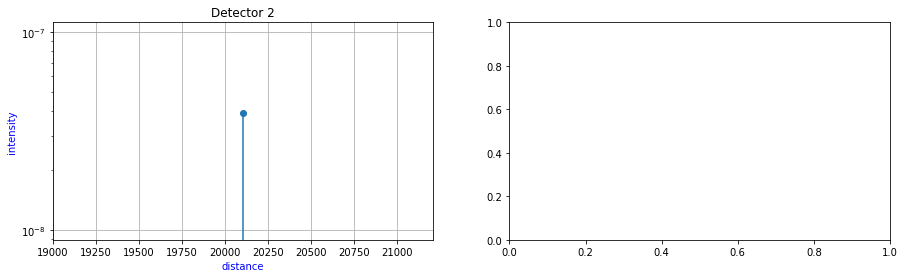

number of reproduced pulses: 3
Wall time: 1.71 s


,Detector,Cycle,Light
0,2,20105,3.883027e-08


In [12]:
%%time
t0 = 0 #starting time
Intensity = 1 #initial laser pulse intensity
res = []
pulse_counter = []
#launch a pulse into the system
result = run_plot(Intensity, pol0, xL, direction, t0, arm0).sort_values(by='Cycle', axis=0).reset_index(drop=True)
print('number of reproduced pulses:', len(pulse_counter))
result

In [22]:
tr_rf_50[1][0][2]*pol0

array([[0.+1.j],
       [0.+0.j]])

In [32]:
# Plug&Play scheme
elems = {
    (2, 0):(cir, ((0, 1, 2),(2, 0, 2))),
    (0, 1):(cir, ((0, 1, 2),(2, 0, 2))),
    (1, 1):(FC_PC, None),
    (2, 1):(BS_2x2, ((1, 3, 4, 5),(2, 2, 0, 0))),
    (0, 4):(BS_2x2, ((1, 3, 4, 5),(2, 2, 0, 0))),
    (0, 5):(BS_2x2, ((1, 3, 4, 5),(2, 2, 0, 0))),
    (1, 4):(FC_PC, None),
    (1, 5):(FC_PC, None),
    (3, 5):(pi_shift_after, 40000),
    (4, 5):(FC_PC, None),
    (14, 5):(FC_PC, None),
    (15, 5):(PBS, ((6, 5, 4),(0, 15, 3))),
    (3, 4):(PBS, ((6, 5, 4),(0, 15, 3))),
    (0, 6):(PBS, ((6, 5, 4),(0, 15, 3))),
    (1, 6):(FC_PC, None),
    (10000, 6):(att, 5),
    (10001, 6):(FC_PC, None),
    (34996, 6):(FC_PC, None),
    (34999, 6):(FC_PC, None),
    (35000, 6):(mirror, None)
}

xL = 0 #Laser coordinate
arm0 = 0 #Laser arm
detectors = [(0, 2), (0, 3)] #Coordinates and arms for detectors
pol0 = np.array([[1], [0]]) #initial polarization
direction = 1 #initial direction

#the scheme vizualization
nt = Network("600px", "900px", notebook=True, heading='')
elms = elems.copy()
elms.update({(xL, arm0): ('Lazer', None), detectors[0]: ('SPD', None), detectors[1]: ('SPD', None)})
nxg = build_graph(elms)
nt.from_nx(nxg)
nt.show('example.html')



Below is the optical scheme built in the Visio 2016 program
![title](перваянежная.png)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


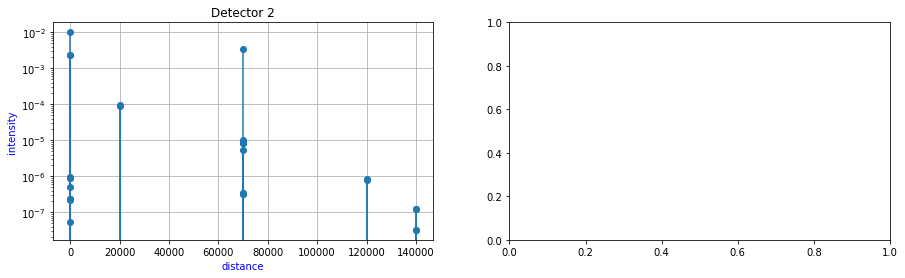

number of reproduced pulses: 1594
Wall time: 1min 53s


,Detector,Cycle,Light
0,2,6,9.997237e-03
1,2,36,2.349801e-03
2,2,40,2.302616e-03
3,2,42,9.396609e-07
4,2,44,2.302192e-07
5,2,46,9.207920e-07
6,2,56,2.347638e-07
7,2,60,9.201986e-07
8,2,62,2.300285e-07
9,2,64,2.254301e-07


In [33]:
%%time
t0 = 0 #starting time
Intensity = 1 #initial laser pulse intensity
res = []
pulse_counter = []
#launch a pulse into the system
result = run_plot(Intensity, pol0, xL, direction, t0, arm0).sort_values(by='Cycle', axis=0).reset_index(drop=True)
print('number of reproduced pulses:', len(pulse_counter))
result

In [9]:
# Simple go-and-return scheme for SR, without connectors
elems = {
    (3, 0):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (2, 1):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (0, 3):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (0, 2):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (1, 3):(att, 70),
    #(2, 3):(pi_shift_after, 500),
    (3, 2):(PBS, ((4, 3, 2),(0, 15, 3))),
    (15, 3):(PBS, ((4, 3, 2),(0, 15, 3))),
    (0, 4):(PBS, ((4, 3, 2),(0, 15, 3))),
    (1002, 4):(cir, ((7, 4, 5), (0, 1002, 0))),
    (0, 5):(cir, ((7, 4, 5), (0, 1002, 0))),
    (0, 7):(cir, ((7, 4, 5), (0, 1002, 0))),
    (1, 7):(pol_rotation, (np.pi/30, np.pi/30)),
    (10002, 5):(cir, ((5, 6, 7), (10002, 0, 6))),
    (0, 6):(cir, ((5, 6, 7), (10002, 0, 6))),
    (6, 7):(cir, ((5, 6, 7), (10002, 0, 6))),
    (3, 6):(mirror, None)
}
print(elems)
xL = 0 #Laser coordinate
arm0 = 0 #Laser arm
detectors = [(-2, 1), (-1, 0)] #Coordinates and arms for detectors
#here the laser considered to be transparent for back going pulse. To not introduce a circulator
pol0 = np.array([[1], [0]]) #initial polarization
direction = 1 #initial direction

#the scheme vizualization
nt = Network("600px", "900px", notebook=True, heading='')
elms = elems.copy()
elms.update({(xL, arm0): ('Lazer', None), detectors[0]: ('SPD', None), detectors[1]: ('SPD', None)})

nxg = build_graph(elms)
nt.from_nx(nxg)
nt.show('example.html')

{(3, 0): (<function BS_2x2 at 0x0000026A76D46DC8>, ((0, 1, 2, 3), (3, 2, 0, 0))), (2, 1): (<function BS_2x2 at 0x0000026A76D46DC8>, ((0, 1, 2, 3), (3, 2, 0, 0))), (0, 3): (<function BS_2x2 at 0x0000026A76D46DC8>, ((0, 1, 2, 3), (3, 2, 0, 0))), (0, 2): (<function BS_2x2 at 0x0000026A76D46DC8>, ((0, 1, 2, 3), (3, 2, 0, 0))), (1, 3): (<function att at 0x0000026A76D46B88>, 70), (3, 2): (<function PBS at 0x0000026A76D5B678>, ((4, 3, 2), (0, 15, 3))), (15, 3): (<function PBS at 0x0000026A76D5B678>, ((4, 3, 2), (0, 15, 3))), (0, 4): (<function PBS at 0x0000026A76D5B678>, ((4, 3, 2), (0, 15, 3))), (1002, 4): (<function cir at 0x0000026A76D5BAF8>, ((7, 4, 5), (0, 1002, 0))), (0, 5): (<function cir at 0x0000026A76D5BAF8>, ((7, 4, 5), (0, 1002, 0))), (0, 7): (<function cir at 0x0000026A76D5BAF8>, ((7, 4, 5), (0, 1002, 0))), (1, 7): (<function pol_rotation at 0x0000026A76D5B8B8>, (0.10471975511965977, 0.10471975511965977)), (10002, 5): (<function cir at 0x0000026A76D5BAF8>, ((5, 6, 7), (10002, 0, 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


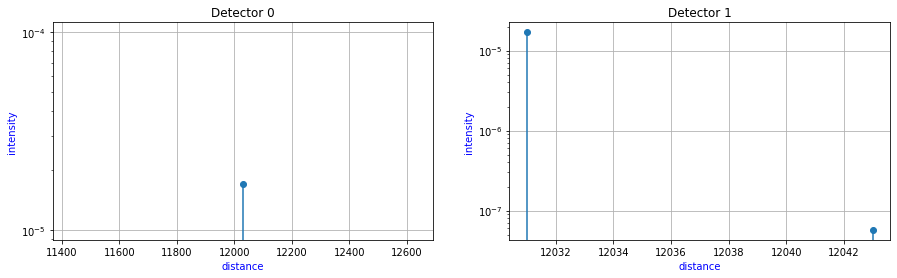

number of reproduced pulses: 7
Visibility:  1
Wall time: 1.17 s


,Detector,Cycle,Light
0,0,12031,1.700898e-05
1,1,12031,1.700898e-05
2,1,12043,5.727285e-08


In [10]:
%%time
t0 = 0 #starting time
Intensity = 1 #initial laser pulse intensity
res = []
pulse_counter = []
#launch a pulse into the system
result = run_plot(Intensity, pol0, xL, direction, t0, arm0).sort_values(by='Cycle', axis=0).reset_index(drop=True)
print('number of reproduced pulses:', len(pulse_counter))
print('Visibility: ', visibility(result, 12043))
result

In [27]:
#SR scheme with connectors and 60dB in MZI arm
elems = {
    (3, 0):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (2, 1):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (0, 3):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (0, 2):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (1, 3):(att, 60),
    (2, 3):(FC_PC, None),
    (4, 3):(FC_PC, None),
    (14, 3):(FC_PC, None),
    (2, 2):(FC_PC, None),    
    (3, 2):(PBS, ((4, 3, 2),(0, 15, 3))),
    (15, 3):(PBS, ((4, 3, 2),(0, 15, 3))),
    (0, 4):(PBS, ((4, 3, 2),(0, 15, 3))),
    (1, 4):(FC_PC, None),
    (1001, 4):(FC_PC, None),
    (1002, 4):(cir, ((7, 4, 5), (0, 1002, 0))),
    (0, 5):(cir, ((7, 4, 5), (0, 1002, 0))),
    (0, 7):(cir, ((7, 4, 5), (0, 1002, 0))),
    (1, 5):(FC_PC, None),
    (10001, 5):(FC_PC, None),
    (10002, 5):(cir, ((5, 6, 7), (10002, 0, 6))),
    (0, 6):(cir, ((5, 6, 7), (10002, 0, 6))),
    (6, 7):(cir, ((5, 6, 7), (10002, 0, 6))),
    (1, 6):(FC_PC, None),
    (3, 6):(mirror_PC, None),
    (5, 7):(FC_PC, None),
    (1, 7):(FC_PC, None)
}

xL = 0 #Laser coordinate
arm0 = 0 #Laser arm
detectors = [(0, 1), (-1, 0)] #Coordinates and arms for detectors
pol0 = np.array([[1], [0]]) #initial polarization
direction = 1 #initial direction

#the scheme vizualization
nt = Network("600px", "900px", notebook=True, heading='')
elms = elems.copy()
elms.update({(xL, arm0): ('Lazer', None), detectors[0]: ('SPD', None), detectors[1]: ('SPD', None)})
nxg = build_graph(elms)
nt.from_nx(nxg)
nt.show('example.html')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


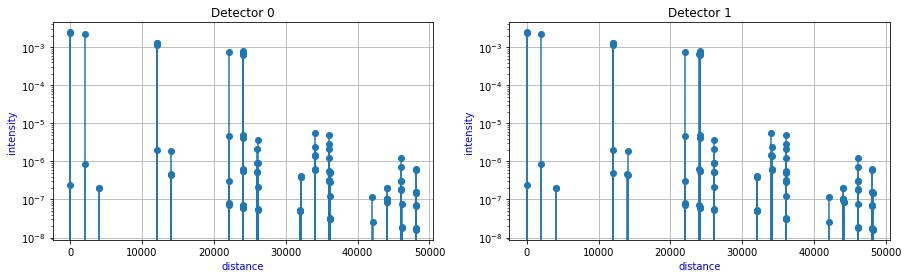

number of reproduced pulses: 5617
Wall time: 28.6 s


,Detector,Cycle,Light
0,1,9,2.498964e-03
1,0,11,2.498734e-03
2,1,13,2.448784e-03
3,0,15,2.448558e-03
4,1,17,2.448333e-07
...,...,...,...
194,0,48131,1.483619e-07
195,1,48133,1.453961e-07
196,0,48135,1.453827e-07
197,1,48137,1.583071e-08


In [30]:
%%time
t0 = 0 #starting time
Intensity = 1 #initial laser pulse intensity
res = []
pulse_counter = []
#launch a pulse into the system
result = run_plot(Intensity, pol0, xL, direction, t0, arm0).sort_values(by='Cycle', axis=0).reset_index(drop=True)
print('number of reproduced pulses:', len(pulse_counter))
result

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


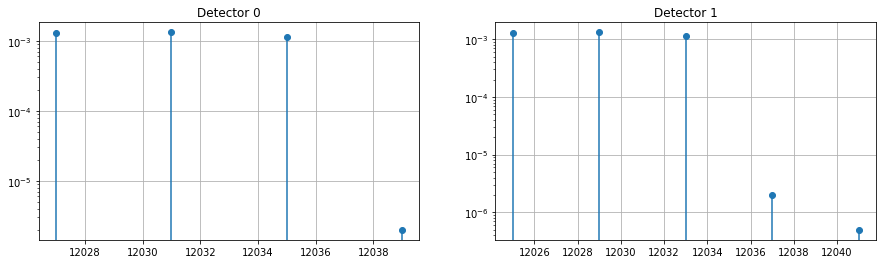

In [32]:
plot(result[result.Cycle.isin(range(12020, 12060))])

In [32]:
#SR scheme with connectors and 60dB in MZI arm
#No connectors in Alice's tail!
elems = {
    (3, 0):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (2, 1):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (0, 3):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (0, 2):(BS_2x2, ((0, 1, 2, 3),(3, 2, 0, 0))),
    (1, 3):(att, 60),
    (2, 3):(FC_PC, None),
    (4, 3):(FC_PC, None),
    (14, 3):(FC_PC, None),
    (2, 2):(FC_PC, None),    
    (3, 2):(PBS, ((4, 3, 2),(0, 15, 3))),
    (15, 3):(PBS, ((4, 3, 2),(0, 15, 3))),
    (0, 4):(PBS, ((4, 3, 2),(0, 15, 3))),
    (1, 4):(FC_PC, None),
    (1001, 4):(FC_PC, None),
    (1002, 4):(cir, ((7, 4, 5), (0, 1002, 0))),
    (0, 5):(cir, ((7, 4, 5), (0, 1002, 0))),
    (0, 7):(cir, ((7, 4, 5), (0, 1002, 0))),
    (1, 5):(FC_PC, None),
    (10001, 5):(FC_PC, None),
    (10002, 5):(cir, ((5, 6, 7), (10002, 0, 6))),
    (0, 6):(cir, ((5, 6, 7), (10002, 0, 6))),
    (6, 7):(cir, ((5, 6, 7), (10002, 0, 6))),    
    (3, 6):(mirror, None),
    (5, 7):(FC_PC, None),
    (1, 7):(FC_PC, None)
}

xL = 0 #Laser coordinate
arm0 = 0 #Laser arm
detectors = [(0, 1), (-1, 0)] #Coordinates and arms for detectors
pol0 = np.array([[1], [0]]) #initial polarization
direction = 1 #initial direction

#the scheme vizualization
nt = Network("600px", "900px", notebook=True, heading='')
elms = elems.copy()
elms.update({(xL, arm0): ('Lazer', None), detectors[0]: ('SPD', None), detectors[1]: ('SPD', None)})
nxg = build_graph(elms)
nt.from_nx(nxg)
nt.show('example.html')

Graphic representation of the optical circuit built in Visio 2016
![title](Псоледняя.png)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


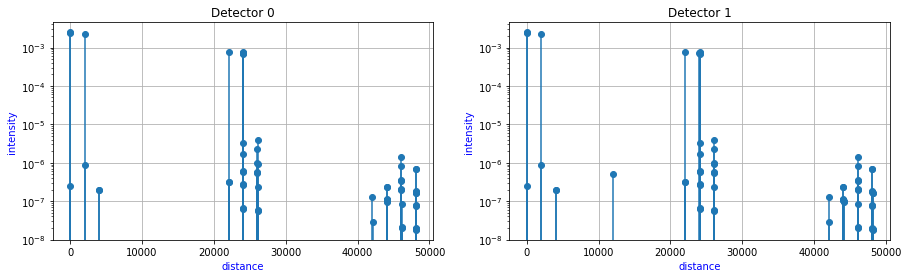

number of reproduced pulses: 1995
Wall time: 30.4 s


,Detector,Cycle,Light
0,1,9,2.498964e-03
1,0,11,2.498734e-03
2,1,13,2.448784e-03
3,0,15,2.448558e-03
4,1,17,2.448333e-07
...,...,...,...
120,0,48131,1.673786e-07
121,1,48133,1.640327e-07
122,0,48135,1.640175e-07
123,1,48137,1.785987e-08


In [29]:
%%time
t0 = 0 #starting time
Intensity = 1 #initial laser pulse intensity
res = []
pulse_counter = []
#launch a pulse into the system
result = run_plot(Intensity, pol0, xL, direction, t0, arm0).sort_values(by='Cycle', axis=0).reset_index(drop=True)
print('number of reproduced pulses:', len(pulse_counter))
result

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


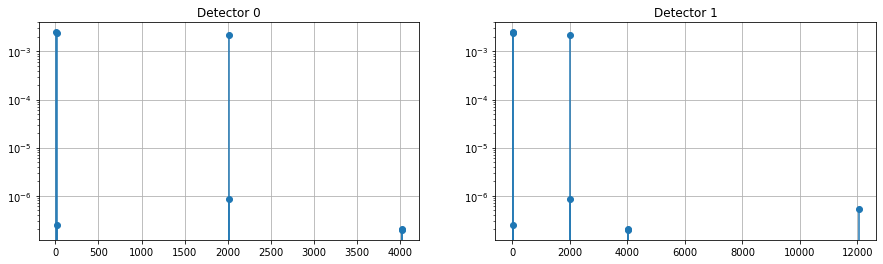

,Detector,Cycle,Light
14,1,12041,5.194359e-07


In [37]:
plot(result[result.Cycle.isin(range(0, 12060))])
result[result.Cycle.isin(range(10000, 12060))]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


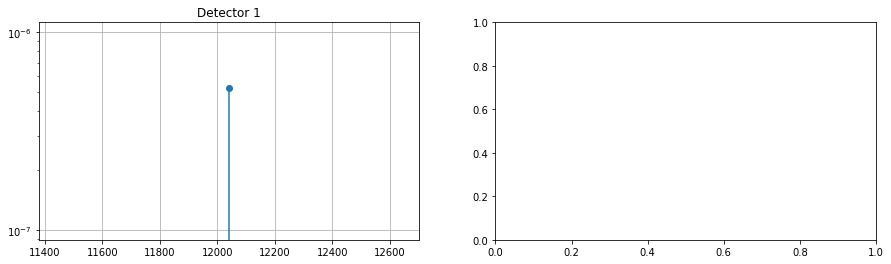

In [38]:
plot(result[result.Cycle.isin(range(12020, 12060))])